### Initialize RV and LV trees

In [1]:
running_on = "jupyter" # "colab", "jupyter", "cluster"

In [2]:
import time
start_time = time.time()

In [3]:
if running_on == "cluster":
    # To run as a python file in cluster
    import os
    import sys
    os.chdir('./PurkinjeECG')
    sys.path.insert(0, os.getcwd())
    
elif running_on == "jupyter":
    %cd ./PurkinjeECG
    %reload_ext autoreload
    %autoreload 2
    
elif running_on == "colab":
    %cd "/content/PurkinjeECG"
    %reload_ext autoreload
    %autoreload 2

# from bo_purkinje import BO_Purkinje

/mnt/sdb/Pipe/Proyectos_FS/Codes/purkinje-learning-paper/preliminary_figures/PurkinjeECG


In [4]:
# if running_on == "cluster":
#     os.chdir('../JAX-BO')
#     sys.path.insert(0, os.getcwd())
    
# elif running_on == "jupyter":
#     %cd ../JAX-BO
    
# elif running_on == "colab":
#     %cd /content/JAX-BO
    
# from bo_ecg import BO_ecg

In [5]:
import numpy as onp
import jax.numpy as np
from jax.config import config
config.update("jax_enable_x64", True)

# from jax import random, lax
# from jaxbo.models import GP
# from jaxbo.utils import normalize

import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd

onp.random.seed(1234)

In [6]:
# if running_on == "cluster":
#     os.chdir('../PurkinjeECG')

# elif running_on == "jupyter":
#     %cd ../PurkinjeECG

# elif running_on == "colab":
#     %cd /content/PurkinjeECG

### Define variables

In [7]:
# mse_jaxbo
dim = 2

## parameters to find
# true_x = []
true_x = "Not known"

def var_parameters_dict(var_parameters_names):
    var_parameters = {}
    
    # init_length
    if "init_length" in var_parameters_names:
        lb_init_length  = 30.0 * np.ones(dim) # 5
        ub_init_length  = 100.0 * np.ones(dim) # 55
        var_parameters["init_length"] = [lb_init_length, ub_init_length, "uniform"]
        # true_x += [30, 36.44783584]

    # length
    if "length" in var_parameters_names:
        lb_length = 4. * np.ones(1)
        ub_length = 12. * np.ones(1)
        var_parameters["length"] = [lb_length, ub_length, "uniform"]
        # true_x += [length, length]

    # w
    if "w" in var_parameters_names:
        lb_w = 0.05* np.ones(1) # 0.05
        ub_w = 0.25 * np.ones(1) # 0.8
        var_parameters["w"] = [lb_w, ub_w, "uniform"]
        # true_x += [w, w]

    # l_segment
    if "l_segment" in var_parameters_names:
        lb_l_segment = 1. * np.ones(dim)
        ub_l_segment = 15. * np.ones(dim)
        var_parameters["l_segment"] = [lb_l_segment, ub_l_segment, "uniform"]
        # true_x += [l_segment, l_segment]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        lb_fascicles_length = 2.0 * np.ones(2*dim) # 10 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_length = 50.0 * np.ones(2*dim) # 30
        var_parameters["fascicles_length"] = [lb_fascicles_length, ub_fascicles_length, "uniform"]
        # true_x += 2 * f_len

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        lb_fascicles_angles = -1./4. * onp.pi * np.ones(2*dim) # 0.1 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_angles = 3./4. * onp.pi * np.ones(2*dim) # 1.57
        var_parameters["fascicles_angles"] = [lb_fascicles_angles, ub_fascicles_angles, "uniform"]
        # true_x += 2 * f_angles

    # branch_angle
    if "branch_angle" in var_parameters_names:
        lb_branch_angle  = 5. * onp.pi/180. * np.ones(1)
        ub_branch_angle  = 45. * onp.pi/180. * np.ones(1)
        var_parameters["branch_angle"] = [lb_branch_angle, ub_branch_angle, "uniform"]
        # true_x += [branch_angle, branch_angle]
    
    # root_time
    if "root_time" in var_parameters_names:
        lb_root_time  = -75. * np.ones(1)
        ub_root_time  = 50. * np.ones(1)
        var_parameters["root_time"] = [lb_root_time, ub_root_time, "uniform"]
        
    # cv
    if "cv" in var_parameters_names:
        lb_cv  = 2. * np.ones(1)
        ub_cv  = 4. * np.ones(1)
        var_parameters["cv"] = [lb_cv, ub_cv, "uniform"]
        
    return var_parameters


def initial_values(var_parameters_names, patient, meshes_list_pat):
    # initial values for parameters    
    meshes_list = meshes_list_pat
    init_length = 30
    length = 8. # [mm]
    w = 0.1
    l_segment = 1.0

    f_len = [20.0,20.0] 
    f_angles = [1.,1.] 

    branch_angle = 0.15 #20. * onp.pi/180. #0.15
    N_it = 20

    # we assign 1. to the parameters to find (in the case with the real ecg this 
#     is irrelevant)
    # init_length
    if "init_length" in var_parameters_names:
        # the initial value for the parameter init_length does not matter, because after it is modified in run_ECG()
        init_length_bo = 1.
    else:
        init_length_bo = init_length 

    # length
    if "length" in var_parameters_names:
        length_bo = 1.
    else:
        length_bo = length # [mm]

    # w
    if "w" in var_parameters_names:
        w_bo = 1.
    else:
        w_bo = w
        
    # l_segment
    if "l_segment" in var_parameters_names:
        l_segment_bo = 1.
    else:
        l_segment_bo = l_segment # [mm]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        f_len_bo = [1., 1.]
    else:
        f_len_bo = f_len

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        f_angles_bo = [1., 1.] 
    else:
        f_angles_bo = f_angles

    # branch_angle
    if "branch_angle" in var_parameters_names:
        branch_angle_bo = 1.
    else:
        branch_angle_bo = branch_angle # importante (dejarlo al final)

    parameters_values = {"patient": patient,
                         "meshes_list": meshes_list, 
                         "init_length": init_length_bo, 
                         "length": length_bo, 
                         "w": w_bo, 
                         "l_segment": l_segment_bo, 
                         "fascicles_length": f_len_bo, 
                         "fascicles_angles": f_angles_bo, 
                         "branch_angle": branch_angle_bo, 
                         "N_it": N_it}
    return parameters_values

In [8]:
var_parameters_list = ["init_length", "fascicles_length", "fascicles_angles","root_time", "cv"]
var_parameters = var_parameters_dict(var_parameters_list)

### Obtain patients results

In [9]:
class patient_results():
    def __init__(self, patient_n, N, nIter, criterion_bo, list_var_par):
        self.patient_number       = patient_n
        self.N                    = N
        self.nIter                = nIter
        self.criterion_bo         = criterion_bo
        self.list_variable_params = list_var_par
        
        # Load params
        if self.patient_number == 1:
            self.patient = "data/crt001/crt001-19"
            self.qrs_in, self.qrs_fin = 200, 400
#             self.meshes_list_pat = [2701, 1293, 86, 770]

        elif self.patient_number == 3:
            self.patient = "data/crt003/crt003-04"
            self.qrs_in, self.qrs_fin = 0, 800
            assert 1==2, "Archivo .pickle faltante"
#             self.meshes_list_pat = [3415, 94, 1339, 2122]

        elif self.patient_number == 4:
            self.patient = "data/crt004/crt004-05"
            self.qrs_in, self.qrs_fin = 200, 400
#             meshes_list_pat = [2451,2228,1945,2369] # these are for cut meshes
        #     trees_non_valid = 2.5 # Value for non-valid trees

        elif self.patient_number == 12:
            self.patient = "data/crt012/crt012-01"
            self.qrs_in, self.qrs_fin = 200, 420
#             meshes_list_pat = [828, 5193, 5111, 4429]
        #     trees_non_valid = 2.5 # Value for non-valid trees

        elif self.patient_number == 17:
            self.patient = "data/crt017/crt017-07"
            self.qrs_in, self.qrs_fin = 200, 400
#             meshes_list_pat = [569, 2234, 569, 2036]
        #     trees_non_valid = 7. # Value for non-valid trees

        else:
            raise Exception("No valid patient selected")

        if not os.path.exists("./output/patient"+str(self.patient_number)):
            os.makedirs("./output/patient"+str(self.patient_number))
            
        # Load patient ecg: ecg_pat
        dir,model = os.path.split(self.patient)
        pat = model.split('-')[0]
        
        with open(f"{dir}/{pat.upper()}ecg.pickle","rb") as fi:
            self.ecg_pat = pickle.load(fi)
        t_pat = -200 + 1.0*np.arange(self.ecg_pat['E1'].shape[0])

        # names = list(ecg_gt.dtype.names)
        names = list(self.ecg_pat.keys())
        formats = ['f8'] * len(names)
        dtype = dict(names = names, formats=formats)

        arrays = []
        for items in list(self.ecg_pat.items()):
            arrays.append(items[1].mean(axis=1) / 1e3)

        ecg_pat_array = onp.rec.fromarrays(arrays, names=names)

        ecg_pat_full  = ecg_pat_array
        # We manually select the QRS complex
        self.ecg_pat_array = ecg_pat_array[self.qrs_in:self.qrs_fin]
        
        # Obtain results
        self.obtain_final_ecgs()
    
    def obtain_final_ecgs(self):
        file_name = f"./output/patient{self.patient_number}/Coupling_N{self.N}_nIter{self.nIter}_criterion"+str(self.criterion_bo)+ f"_variableparams_{self.list_variable_params}_step1" 

        name_ecg  = f"./output/patient{self.patient_number}/ecg_N{self.N}_nIter{self.nIter}_criterion{self.criterion_bo}_variableparams_{self.list_variable_params}"
        ecg_final = pickle.load(open(name_ecg, "rb"))
        self.ecg_final = pickle.load(open(name_ecg, "rb"))

        self.samples_final = np.load(f"./output/patient{self.patient_number}/X_final_N{self.N}_nIter{self.nIter}_criterion{self.criterion_bo}_variableparams_{self.list_variable_params}.npy")
        
        # Plot the ecgs of all possible trees
        len1 = self.ecg_pat_array.shape[0]
        self.n_candidates_selected = len(self.samples_final)
        
        self.selection_ecg = []
        for ecg_fin_i, ind_fin_i in ecg_final:
            # selection of qrs complex of predicted ecgs
            self.selection_ecg.append(ecg_fin_i[ind_fin_i:ind_fin_i+len1])
            
        # Find mean and std of real ecgs
        arr_mean = []
        # arr_std  = []
        arr_min  = []
        arr_max  = []

        for items in list(self.ecg_pat.items()):
            arr_mean.append(items[1].mean(axis=1) / 1e3)
        #     arr_std.append(items[1].std(axis=1) / 1e3)
            arr_min.append(items[1].min(axis=1) / 1e3)
            arr_max.append(items[1].max(axis=1) / 1e3)
            
        self.ecg_pat_mean = onp.rec.fromarrays(arr_mean, names = list(self.ecg_pat.keys()))
        # self.ecg_pat_std  = onp.rec.fromarrays(arr_std, names = list(ecg_pat.keys()))
        self.ecg_pat_min  = onp.rec.fromarrays(arr_min, names = list(self.ecg_pat.keys()))
        self.ecg_pat_max  = onp.rec.fromarrays(arr_max, names = list(self.ecg_pat.keys()))

In [10]:
# Load results
N            = 250
nIter        = 300
criterion_bo = "EI"

list_variable_params = "_".join(list(var_parameters.keys()))

### Plot final ecgs with mean and min/max

In [11]:
import matplotlib
import matplotlib.font_manager as fm

fm.fontManager.addfont('../Helvetica Neue Bold.ttf')
matplotlib.rc('font', family='Helvetica Neue')


plt.rcParams['font.family'] = u'Helvetica Neue'


plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] ='bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18

In [12]:
# Plot the ecgs of all possible trees
pat1  = patient_results(1,  N, nIter, criterion_bo, list_variable_params)
pat4  = patient_results(4,  N, nIter, criterion_bo, list_variable_params)
pat12 = patient_results(12, N, nIter, criterion_bo, list_variable_params)
pat17 = patient_results(17, N, nIter, criterion_bo, list_variable_params)

patients_results = [pat1, pat4, pat12, pat17]
n_patients = len(patients_results)

leads_order = ('E1', 'E2', 'E3', 'aVR', 'aVL', 'aVF','V1', 'V2', 'V3', 'V4', 'V5', 'V6')

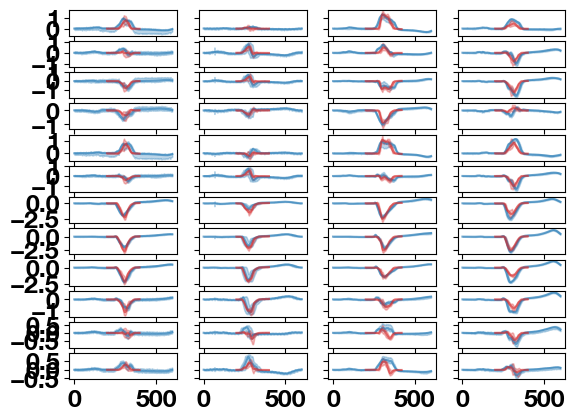

In [13]:
# Find y limits
fig,axs = plt.subplots(12, n_patients, sharex=True, sharey='row')
for lead_i in onp.arange(len(pat1.ecg_pat_array.dtype.names)):
    for pat_i in onp.arange(n_patients):
        ax = axs[lead_i, pat_i]
        l = leads_order[lead_i] # pat1.ecg_pat_array.dtype.names[lead_i]
        
        pat_class = patients_results[pat_i]
        
        # real ecg
        mean_ecgs = pat_class.ecg_pat_mean[l][0:600]
    #     std_ecgs  = pat_class.ecg_pat_std[l][0:600]    
        min_ecgs  = pat_class.ecg_pat_min[l][0:600]
        max_ecgs  = pat_class.ecg_pat_max[l][0:600]

        ax.plot(mean_ecgs,'tab:blue', alpha=0.6, label="Ground truth")
        ax.fill_between(np.arange(len(min_ecgs)), min_ecgs, max_ecgs, color='tab:blue', alpha=.3)

        # predicted ecgs
        n_sel  = len(pat_class.selection_ecg)
        n_time = len(pat_class.selection_ecg[0])
    
        ecg_l = onp.empty((n_sel, n_time))
        for ind in onp.arange(n_sel):
            ecg_l[ind, :] = pat_class.selection_ecg[ind][l]
    
        mean_l = np.mean(ecg_l, axis=0)
#         std_l  = np.std(ecg_l, axis=0)
        min_l  = np.min(ecg_l, axis=0)
        max_l  = np.max(ecg_l, axis=0)
    
        label_BO = "BO (" + str(pat_class.n_candidates_selected) + " trees)"
        ax.plot(pat_class.qrs_in + np.arange(len(mean_l)), mean_l,'tab:red', alpha=0.6, label=label_BO)
        ax.fill_between(pat_class.qrs_in + np.arange(len(min_l)), min_l, max_l, color='tab:red', alpha=.3)

# Calculate normalized heights based on y-limits
heights = []
for lead_i in onp.arange(len(pat1.ecg_pat_array.dtype.names)):
    ax = axs[lead_i, 0]
    heights += [ax.get_ylim()[1] - ax.get_ylim()[0]]
    
# total_height = sum(heights)
# normalized_heights = [h / total_height for h in heights]

# # Calculate positions for subplots
# bottoms = list(1.-onp.cumsum(normalized_heights)[:-1]) + [0.]

# # Adjust subplot positions
# for lead_i in onp.arange(len(pat1.ecg_pat_array.dtype.names)):
#     for pat_i in onp.arange(n_patients):
#         ax = axs[lead_i, pat_i]
#         ax.set_position([ax.get_position().x0, bottoms[lead_i],
#                      ax.get_position().width, normalized_heights[lead_i]])

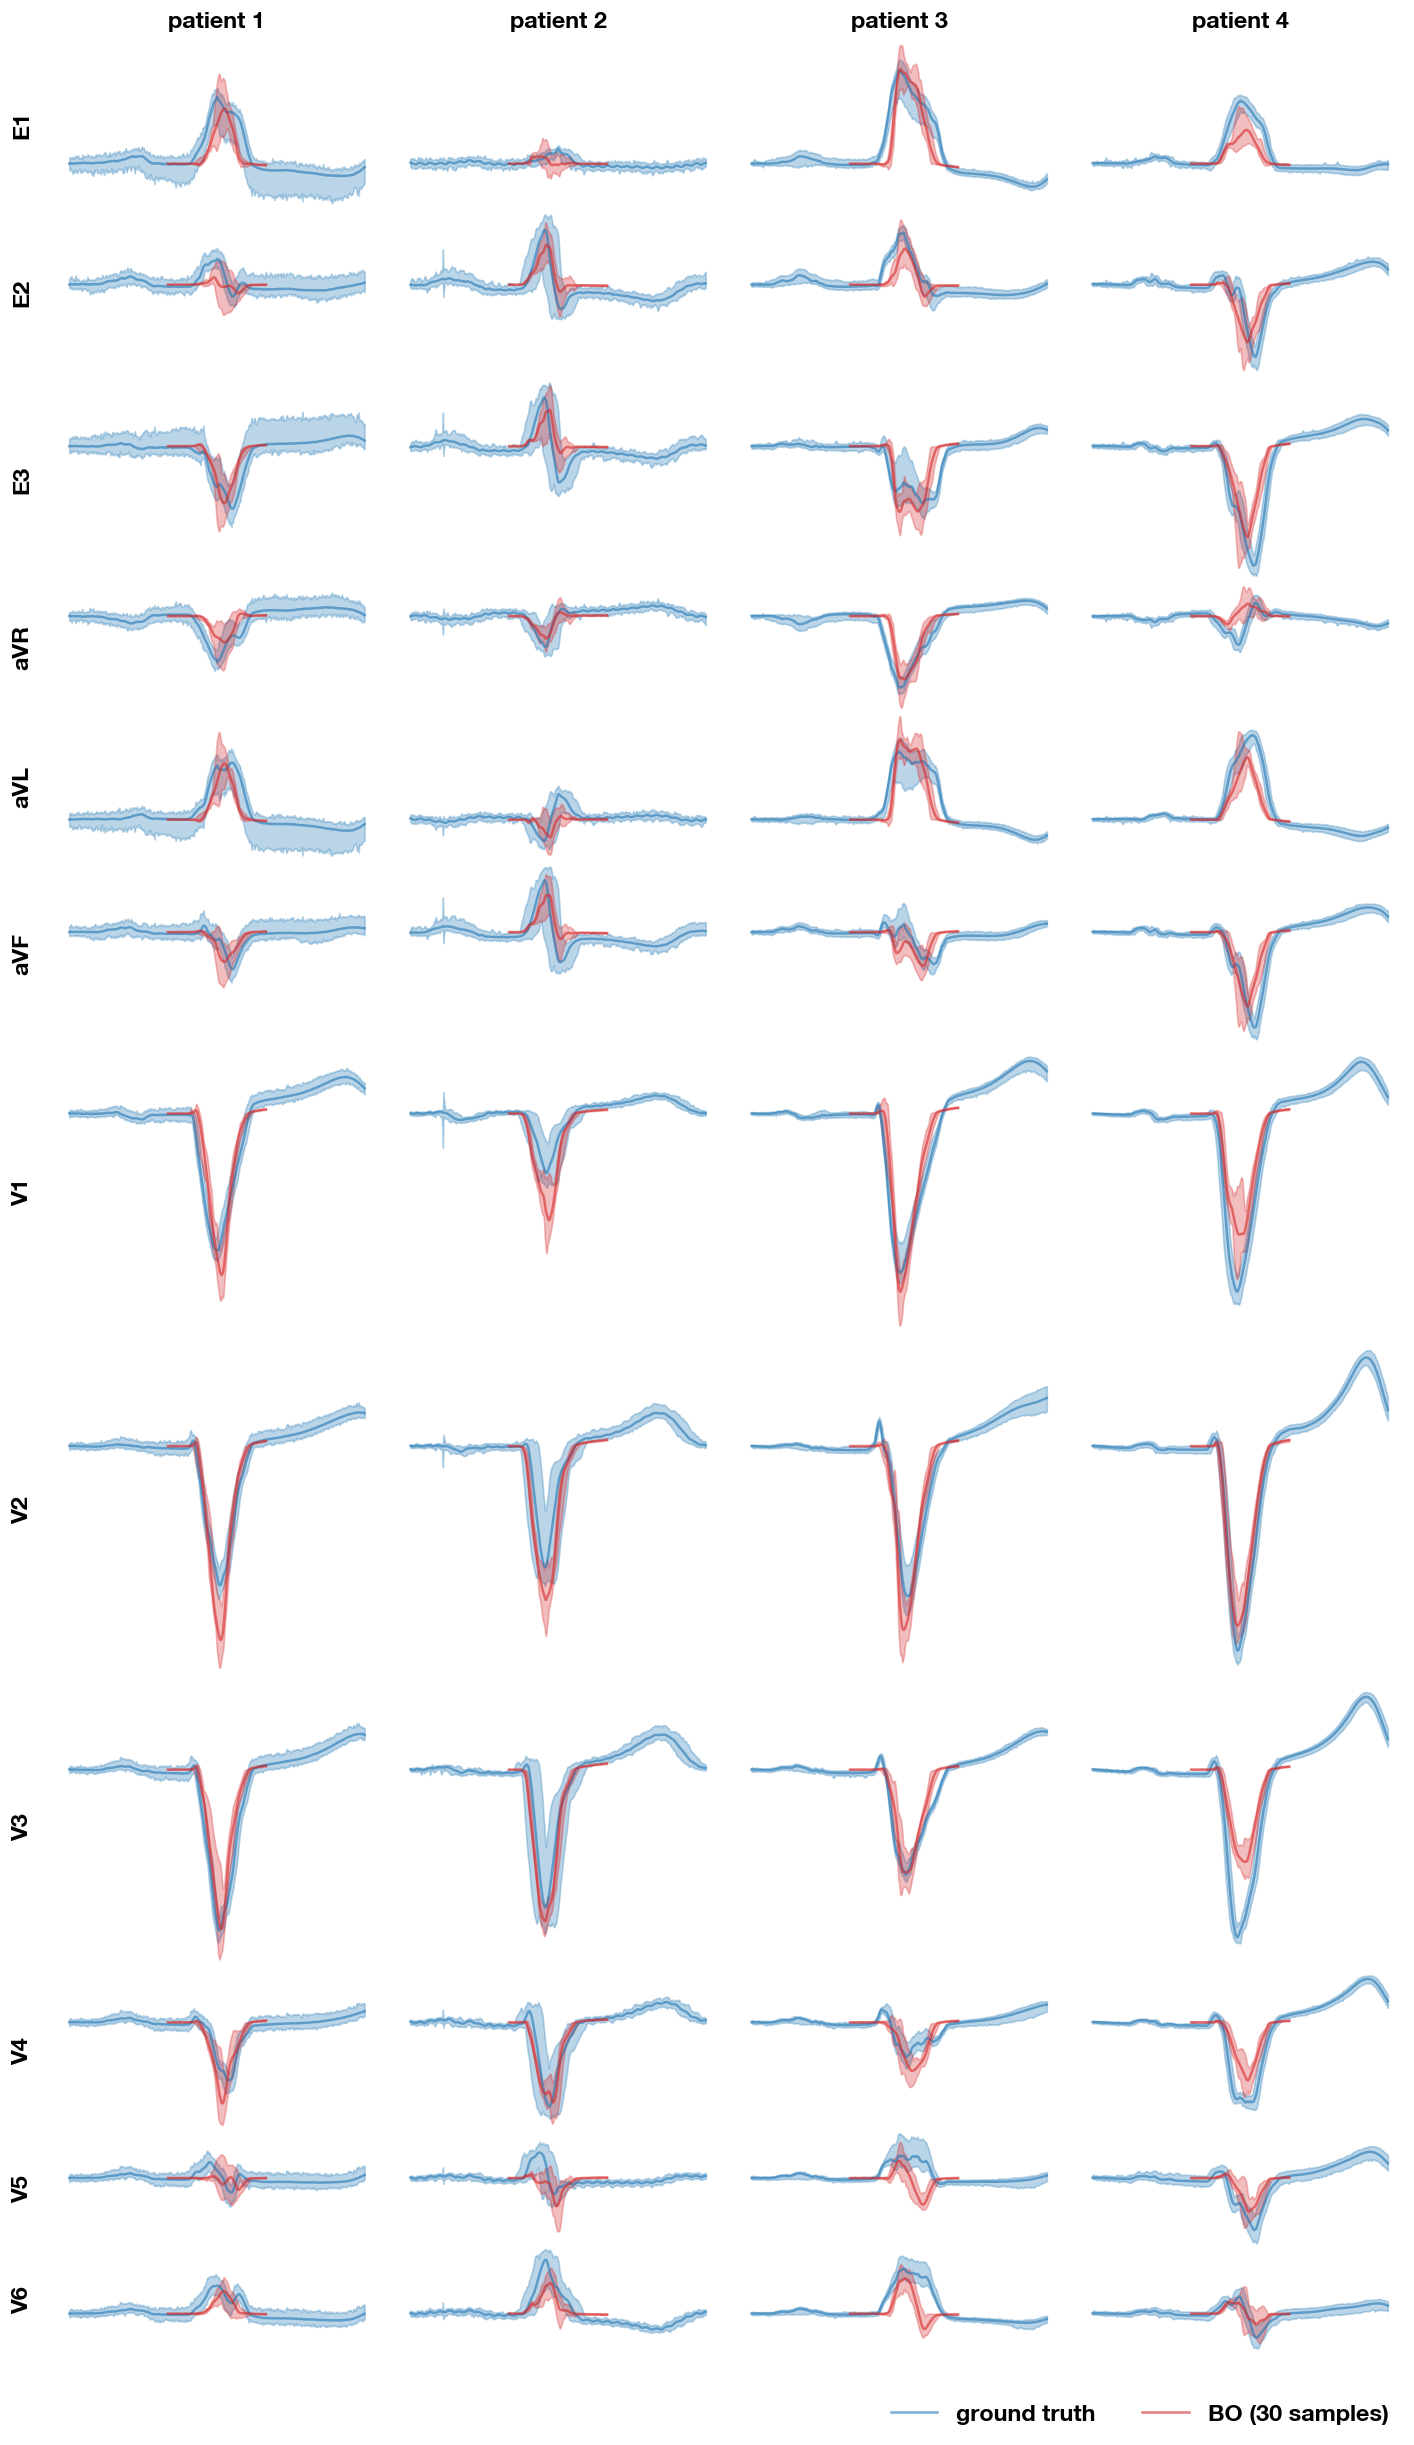

In [25]:
fig,axs = plt.subplots(12, n_patients,
                       figsize=(12,20),
                       dpi=120,
                       gridspec_kw={'height_ratios': heights},
                       sharex=True, sharey='row')

for lead_i in onp.arange(len(pat1.ecg_pat_array.dtype.names)):
    for pat_i in onp.arange(n_patients):
        ax = axs[lead_i, pat_i]
        l = leads_order[lead_i] # pat1.ecg_pat_array.dtype.names[lead_i]
        
        pat_class = patients_results[pat_i]
        
        # real ecg
        mean_ecgs = pat_class.ecg_pat_mean[l][0:600]
    #     std_ecgs  = pat_class.ecg_pat_std[l][0:600]    
        min_ecgs  = pat_class.ecg_pat_min[l][0:600]
        max_ecgs  = pat_class.ecg_pat_max[l][0:600]

        ax.plot(mean_ecgs,'tab:blue', alpha=0.6, label="ground truth")
        ax.fill_between(np.arange(len(min_ecgs)), min_ecgs, max_ecgs, color='tab:blue', alpha=.3)

        # predicted ecgs
        n_sel  = len(pat_class.selection_ecg)
        n_time = len(pat_class.selection_ecg[0])
    
        ecg_l = onp.empty((n_sel, n_time))
        for ind in onp.arange(n_sel):
            ecg_l[ind, :] = pat_class.selection_ecg[ind][l]
    
        mean_l = np.mean(ecg_l, axis=0)
#         std_l  = np.std(ecg_l, axis=0)
        min_l  = np.min(ecg_l, axis=0)
        max_l  = np.max(ecg_l, axis=0)
    
        label_BO = "BO (" + str(pat_class.n_candidates_selected) + " samples)"
        ax.plot(pat_class.qrs_in + np.arange(len(mean_l)), mean_l,'tab:red', alpha=0.6, label=label_BO)
        ax.fill_between(pat_class.qrs_in + np.arange(len(min_l)), min_l, max_l, color='tab:red', alpha=.3)
        
        # ax.grid(linestyle='--',alpha=0.4)
        ax.set_axis_off()

        if pat_i == 0:
            # ax.set_ylabel(l)
            ax.text(-0.1, 0.5, l, rotation=90, va='center', ha='center', transform=ax.transAxes, fontsize=14)

        if lead_i == 0:
            ax.set_title(f"patient {pat_i + 1}", fontsize=14)
#             ax.set_title(f"Patient {pat_class.patient_number}")
            
        # if lead_i == 11 and pat_i == n_patients - 1:
        #     ax.legend(fontsize="18", frameon = False)

# Legend
handles, labels = axs[0,0].get_legend_handles_labels() 
legend = fig.legend(handles, labels, loc = 'upper left', bbox_to_anchor = (0.61,0.), fontsize="14", frameon = False, ncols=2)

fig.tight_layout()
fig.align_ylabels()
plt.subplots_adjust(hspace=-0.025, wspace = 0.05)
fig.savefig("Fig_final_ecgs_patients.pdf", bbox_inches='tight')

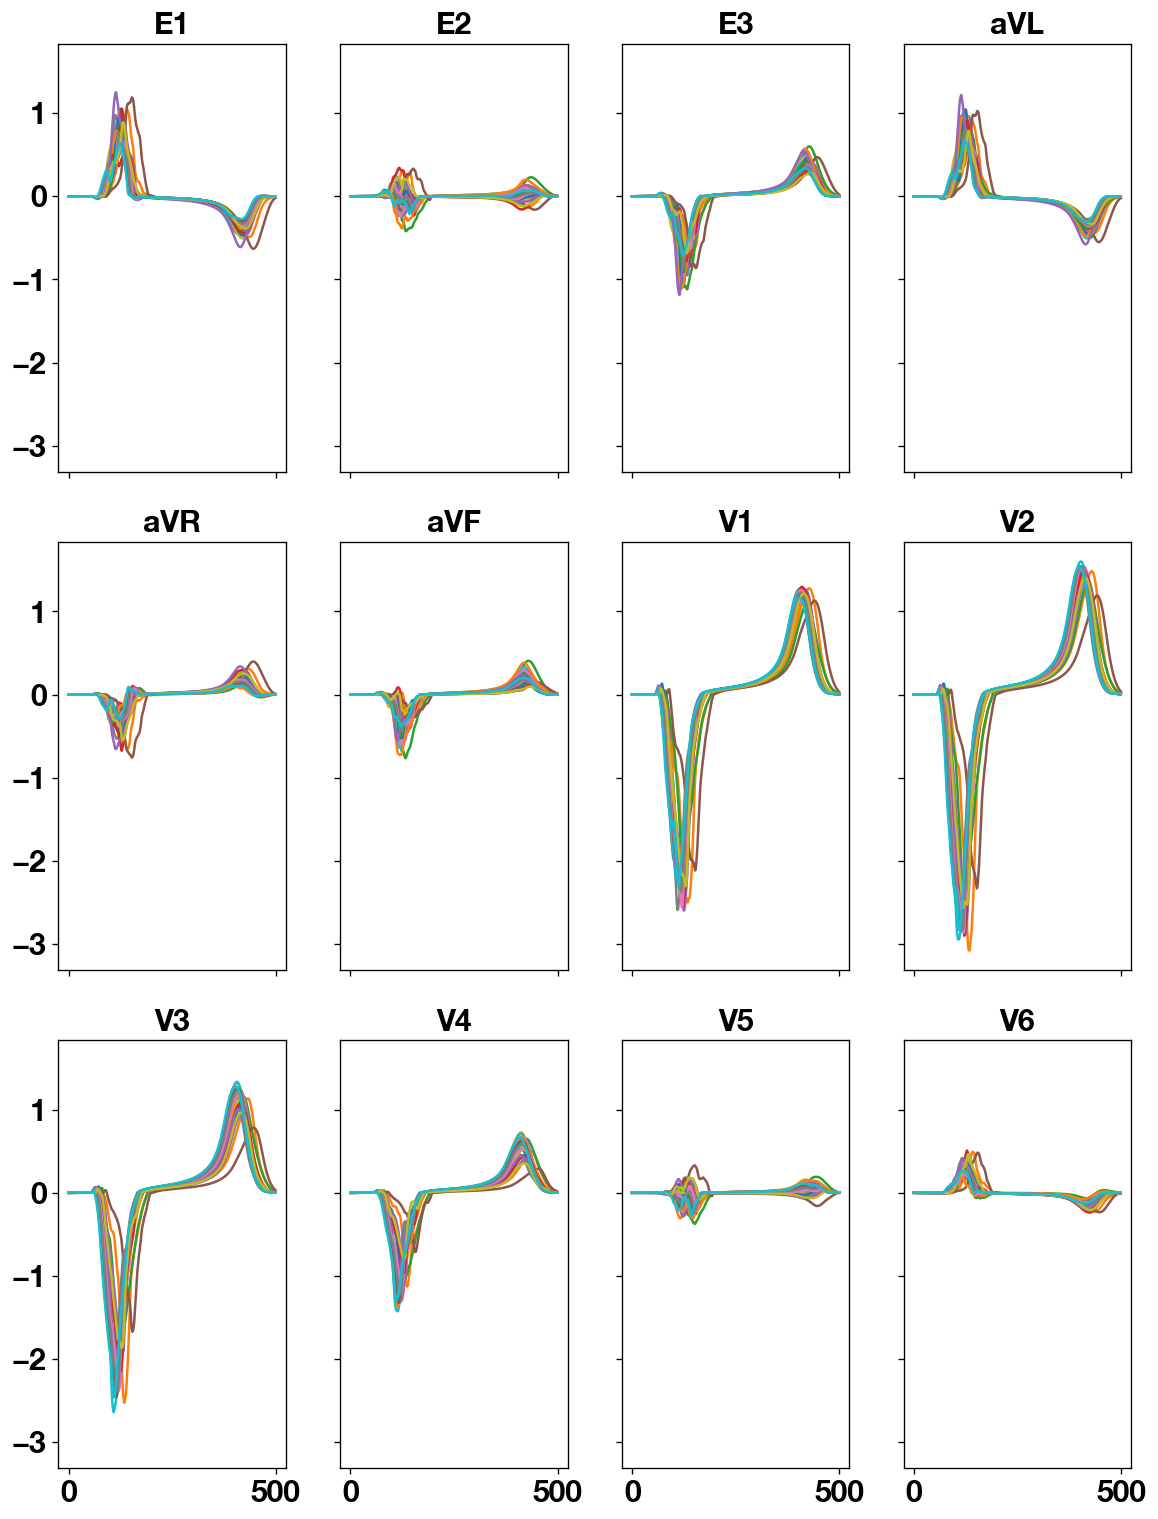

In [15]:
### TEST ###
fig,axs = plt.subplots(3,4,figsize=(10,13),dpi=120,sharex=True,sharey=True)
for ax,l in zip(axs.ravel(), pat1.selection_ecg[0].dtype.names):
    n_sel  = len(pat1.selection_ecg)
    
    for ind in onp.arange(n_sel): # onp.arange(25,30): # 
#         ax.plot(pat1.selection_ecg[ind][l])
        ax.plot(pat1.ecg_final[ind][0][l])

#     ax.grid()
    ax.set_title(l)
    
fig.tight_layout()
plt.show()
### TEST ###

### Final pairplots

In [16]:
# Create columns names for pairplot
df_columns = []
if "init_length" in var_parameters.keys():
    df_columns += [r"$l_{\rm i}^{\rm L}$ [mm]", r"$l_{\rm i}^{\rm R}$ [mm]"] # [r"In. Length L $l^{\rm L}$", "In. Length R"]
    
if "length" in var_parameters.keys():
    df_columns += ["Length"]
    
if "w" in var_parameters.keys():
    df_columns += ["w"]
    
if "fascicles_length" in var_parameters.keys():
    df_columns += [r"$l_{\rm F1}^{\rm L}$ [mm]", r"$l_{\rm F2}^{\rm L}$ [mm]", r"$l_{\rm F1}^{\rm R}$ [mm]", r"$l_{\rm F2}^{\rm R}$ [mm]"] 
    # ["Fas. Length L1", "Fas. Length L2", "Fas. Length R1", "Fas. Length R2"]
    
if "fascicles_angles" in var_parameters.keys():
    df_columns += [r"$\alpha_{\rm F1}^{\rm L}$ [º]", r"$\alpha_{\rm F2}^{\rm L}$ [º]", r"$\alpha_{\rm F1}^{\rm R}$ [º]", r"$\alpha_{\rm F2}^{\rm R}$ [º]"] 
    # ["Fas. Angle L1", "Fas. Angle L2", "Fas. Angle R1", "Fas. Angle R2"]
    
if "branch_angle" in var_parameters.keys():
    df_columns += ["Branch Angle"]
    
if "root_time" in var_parameters.keys():
    df_columns += ["RT [ms]"]
    
if "cv" in var_parameters.keys():
    df_columns += ["CV [m/s]"]

In [17]:
# Find boundaries
lb_params  = np.array([])
ub_params  = np.array([])

for var_name, var_value in var_parameters.items():
    lb_params = np.append(lb_params, var_value[0])
    ub_params = np.append(ub_params, var_value[1])
    
bounds = {'lb': lb_params, 'ub': ub_params}

In [18]:
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'cm'
# from matplotlib import rc

def manual_pair_plot(data_frames, data_colors, bounds):
    num_features = len(data_frames[0].columns)
    fig, axes = plt.subplots(num_features, num_features, figsize=(25, 25), dpi=120)# , sharex=True, sharey=True)
    
    for i, column1 in enumerate(data_frames[0].columns):
        for j, column2 in enumerate(data_frames[0].columns):
            ax = axes[i, j]
            ax.set_xlim((bounds["lb"][j], bounds["ub"][j]))
            
            # Remove top and right spines
            # ax.spines['top'].set_visible(False)
            # ax.spines['right'].set_visible(False)
            
            # Set the thickness of the remaining spines
            ax.spines['left'].set_linewidth(0.4)  # Adjust the linewidth as needed
            ax.spines['bottom'].set_linewidth(0.4)  # Adjust the linewidth as needed
            ax.spines['top'].set_linewidth(0.4)
            ax.spines['right'].set_linewidth(0.4)

            # Adjust the thickness of tick marks
            ax.tick_params(axis='both', which='both', width=0.4)  # Adjust the width as needed            

            if i == j:
#                 for data_frame_i, data_color_i in zip(data_frames, data_colors):
#                     ax.hist(data_frame_i[column1],
#                             range=(bounds["lb"][j], bounds["ub"][j]),
#                             bins=10,
#                             color=data_color_i, # 'tab:blue'
#                             alpha=0.7,
#                             edgecolor='black',
#                             linewidth=0.4) # 'skyblue'
                
                # bar hist
                data_frames_col = []
                for data_frame_i in data_frames:
                    data_frames_col += [data_frame_i[column1]]
                ax.hist(data_frames_col,
                        range=(bounds["lb"][j], bounds["ub"][j]),
                        bins=10,
                        histtype='bar', stacked=True,
                        color=data_colors, # 'tab:blue'
                        alpha=0.8,
                        edgecolor='black',
                        linewidth=0.4) # 'skyblue'
                    
            elif i > j:
                for pat_i, (data_frame_i, data_color_i) in enumerate(zip(data_frames, data_colors)):
                    ax.scatter(data_frame_i[column2],
                               data_frame_i[column1],
                               color=data_color_i, # 'coral'
                               s=8,
                               alpha=0.7,
                               label=f"Patient {pat_i+1}")
            
                ax.set_ylim((bounds["lb"][i], bounds["ub"][i]))
#                 ax.set_xlabel(column2)
#                 ax.set_ylabel(column1)

            else:
                fig.delaxes(ax)

            if i == num_features-1:
                if column2 == "Root time" or column2 == "CV":
                    ax.set_xlabel(column2, labelpad=-15)
                else:
                    ax.set_xlabel(column2, fontsize=20, labelpad=-15)

                ax.set_xticks(ax.get_xlim())
                if "alpha" in column2:
                    ax.set_xticklabels(["%i" % (x*180/np.pi) for x in ax.get_xlim()])
                labels = ax.get_xticklabels()
                labels[0].set_horizontalalignment("left")
                labels[-1].set_horizontalalignment("right")
            else:
#                 ax.set_xticks([])
                ax.set_xticklabels([])
                
            if j == 0:
                if column1 == "Root time" or column1 == "CV":
                    ax.set_ylabel(column1, labelpad=-30)
                else:
                    ax.set_ylabel(column1, fontsize=20, labelpad=-30)
                
                ax.set_yticks(ax.get_ylim())
                if "alpha" in column1:
                    ax.set_yticklabels(["%i" % (x*180/np.pi) for x in ax.get_ylim()])
                labels = ax.get_yticklabels()
                labels[0].set_verticalalignment("bottom")
                labels[-1].set_verticalalignment("top")

#                 print (ax.get_yticks())
#                 print (ax.get_yticklabels())
#                 print (ax.get_ylim())
            else:
                ax.set_yticklabels([])
    
    plt.tight_layout()
    fig.align_ylabels() # axs[:, 1]
    plt.subplots_adjust(wspace=0.05, hspace=0.05)#, left=0.2, right=0.9)

    assert (bounds["lb"][0] == bounds["lb"][1]) and (bounds["ub"][0] == bounds["ub"][1]),\
    "y labels of the first row copied from the second row"
    y_min_h, y_max_h = axes[0,0].get_ylim()
    y_min_d, y_max_d = axes[1,0].get_ylim()
    
    yticks_10  = axes[1,0].get_yticks()
    y_d        = yticks_10[onp.where((yticks_10>=y_min_d) & (yticks_10<=y_max_d))]
    int_y_d    = [int(element) for element in y_d]
    
    y_h = (y_d - y_min_d)/(y_max_d - y_min_d) * (y_max_h - y_min_h) + y_min_h
    
    # axes[0,0].set_yticks(y_h)
    # axes[0,0].set_yticklabels(int_y_d)
    axes[0,0].set_yticks([])

    # Legend
    handles, labels = axes[1,0].get_legend_handles_labels() 
    legend = fig.legend(handles, labels, loc = 'upper left', bbox_to_anchor = (0.04,1.02), ncol = len(data_colors))
    
    # Get the legend's bounding box and center it vertically
    legend_box = legend.get_frame()
    legend_box.set_y(0.5 - legend_box.get_height() / 2)
    for text in legend.get_texts():
        text.set_position((text.get_position()[0], text.get_position()[1] - 0.5))
    
#     plt.tight_layout()
    plt.savefig("Fig_final_pairplot_patients.pdf", bbox_inches='tight')
    plt.show()

In [19]:
# Data Frames
df_p1  = pd.DataFrame(pat1.samples_final, columns = df_columns)
df_p4  = pd.DataFrame(pat4.samples_final, columns = df_columns)
df_p12 = pd.DataFrame(pat12.samples_final, columns = df_columns)
df_p17 = pd.DataFrame(pat17.samples_final, columns = df_columns)

data_frames = [df_p1, df_p4, df_p12, df_p17]

data_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

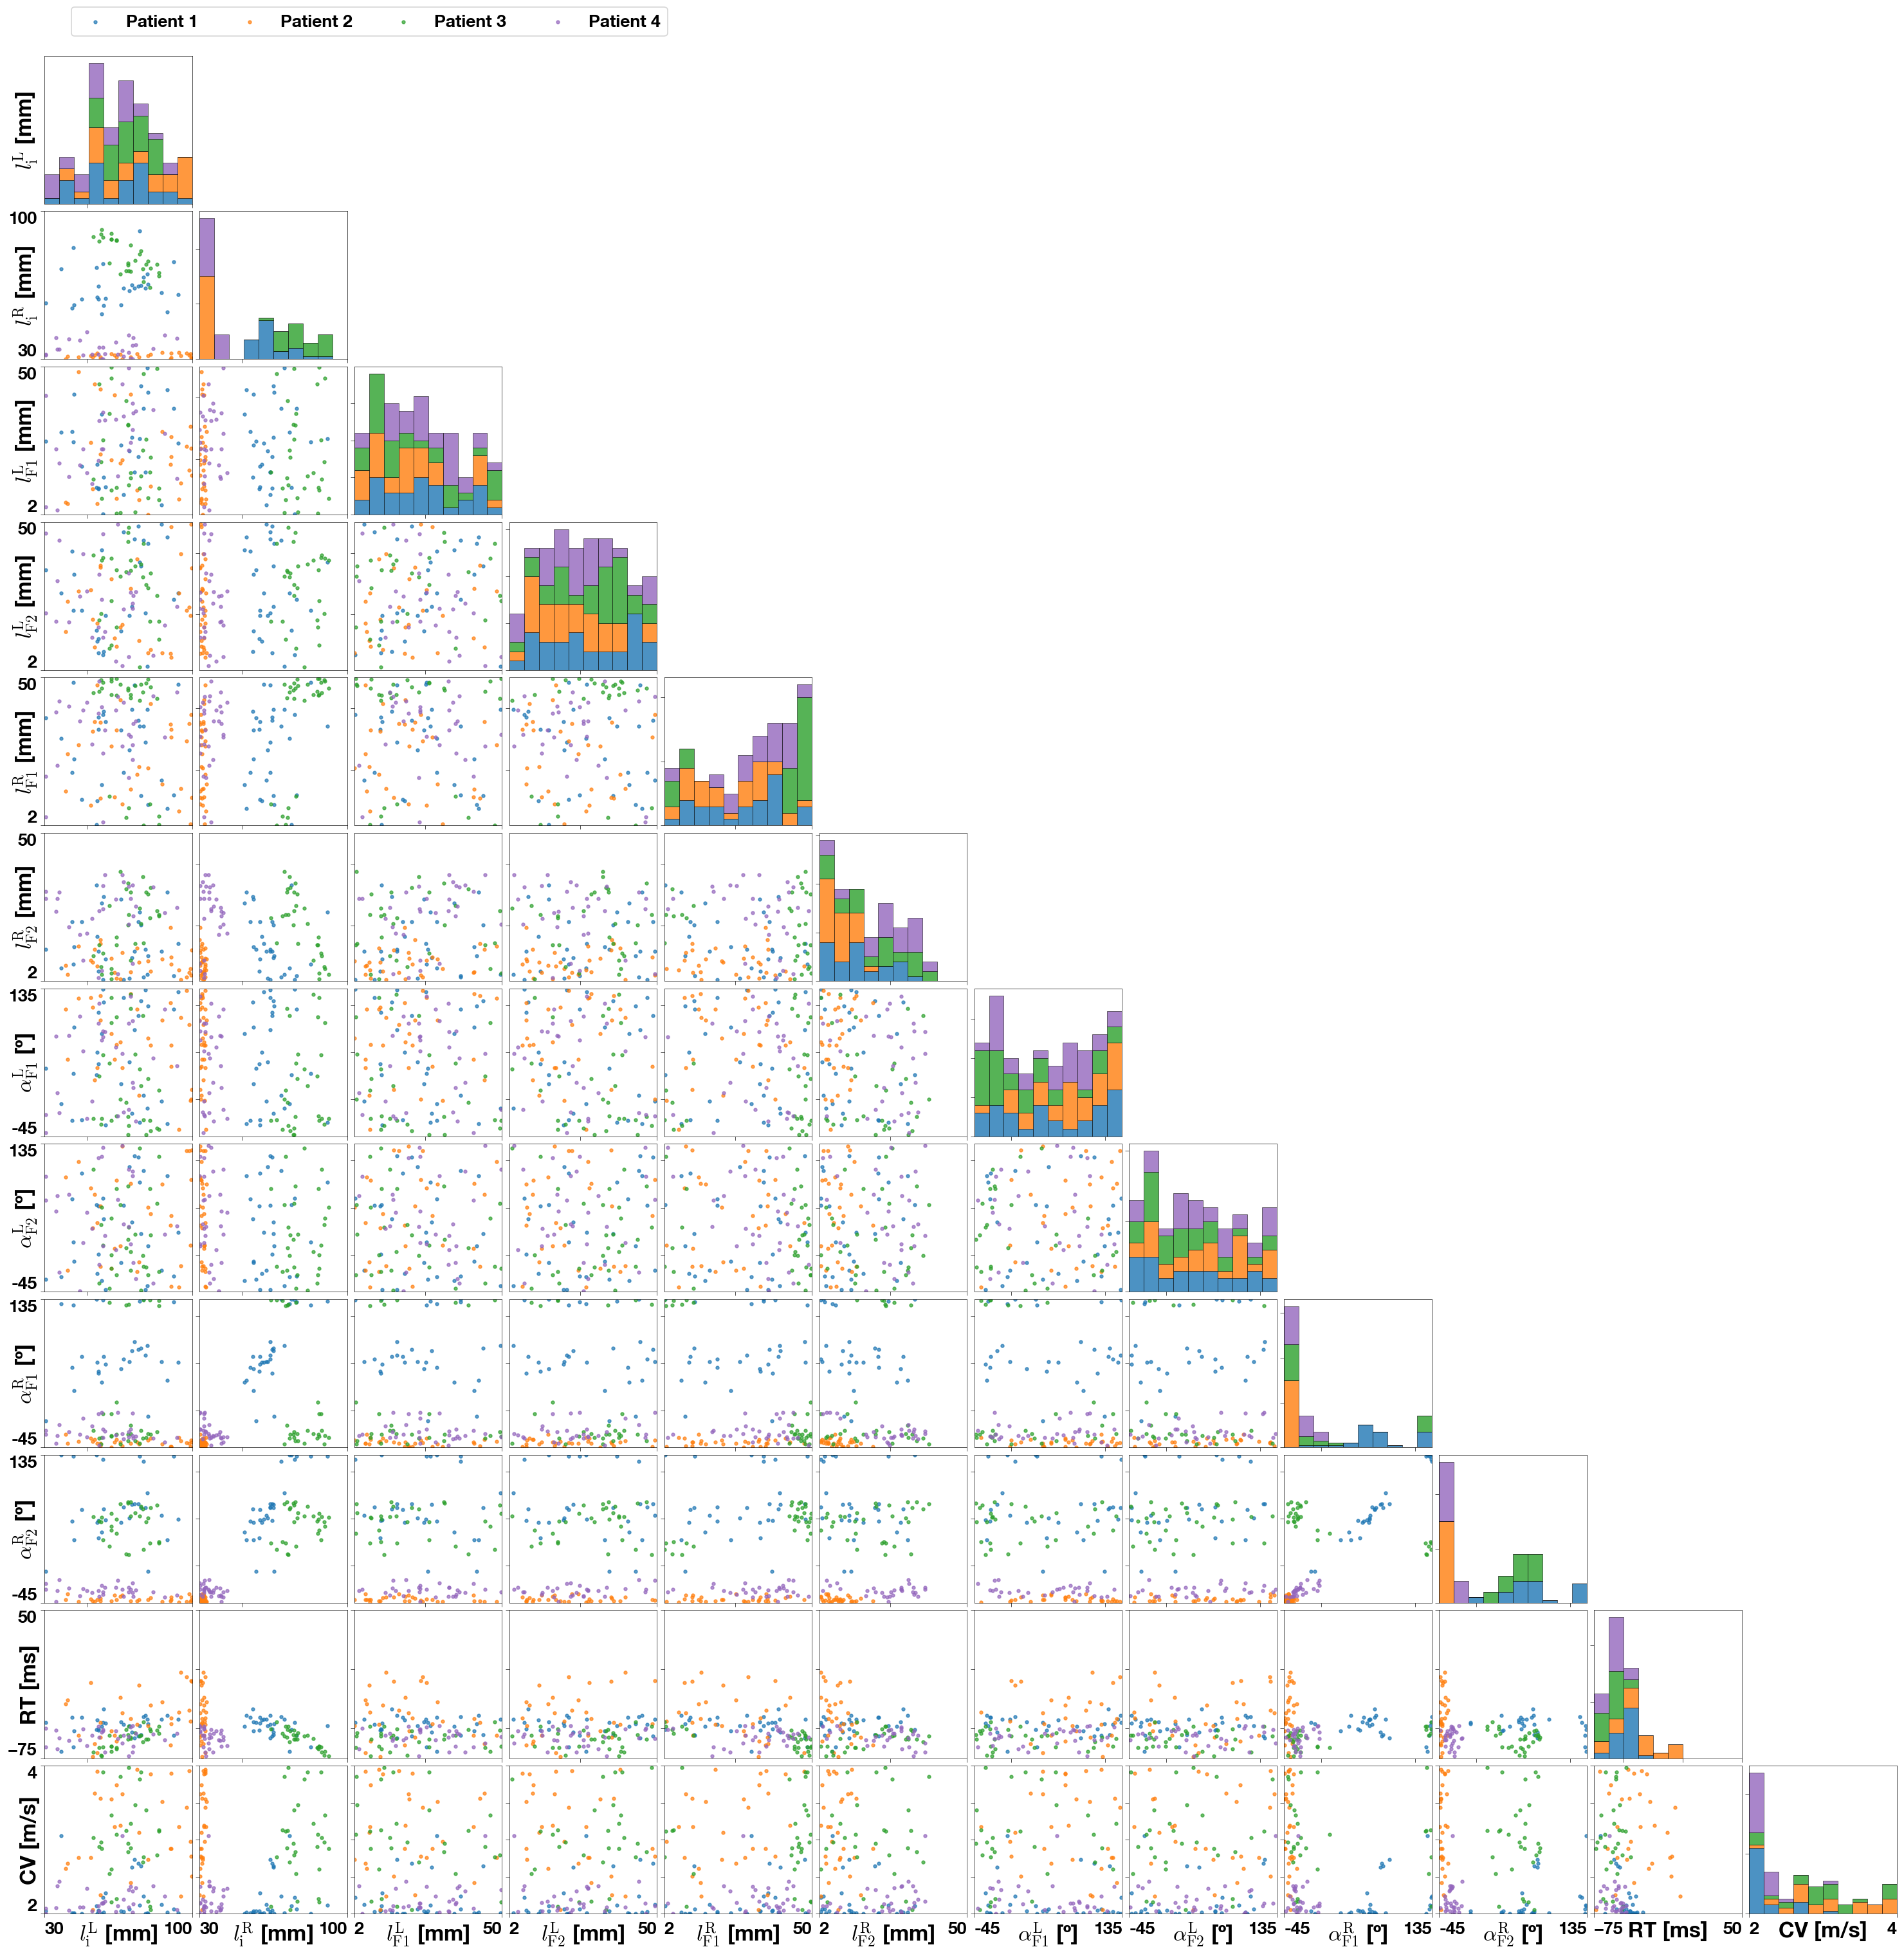

In [20]:
# Pairplots
manual_pair_plot(data_frames, data_colors, bounds)

In [21]:
end_time = time.time()
print("Elapsed time: " + str(end_time - start_time))

Elapsed time: 44.906272649765015
